In [351]:
from sklearn.svm import SVC
from HelperFunctions_ import classesInLabels
import numpy as np
import copy
import time

def SeperateDataLabels(data,labels, seperation): 

    train_data = copy.deepcopy(data)
    train_labels = copy.deepcopy(labels)

    #Check the labels and the seperation have the same number of classes or not 
    # Will remove the classes not in the seperation array. 
    
    if(len(seperation) == 2): 

        classesInSeperation = []

        for i in range(len(seperation)): 
            for j in range(len(seperation[i])): 
                if(not(seperation[i][j] in classesInSeperation)): 
                    classesInSeperation.append(seperation[i][j])

        classesInSeperation.sort()
        classesInSeperation = np.array(classesInSeperation)
        cIL = np.array(classesInLabels(labels))

        #Checks if the seperation and the labels have same amount of classes. If not return -1 ????
        if(not(np.array_equal(cIL, classesInSeperation))): 

            for i in range(len(cIL)): 
                if(not(cIL[i] in classesInSeperation)):
                    train_data = train_data[train_labels != cIL[i]]
                    train_labels = train_labels[train_labels != cIL[i]]

        if(len(classesInLabels(labels)) > 2):  #Remove this if not work
            for i in range(len(seperation)): 
                for j in range(len(seperation[i])):
                    if(seperation[i][j] != min(seperation[i])):
                        train_labels[train_labels == seperation[i][j]] = min(seperation[i])
        
        return train_data, train_labels
        
    else: 
        print("The seperation needs to be 2 in length. For 1v1 classification")
        return -1



def BranchDataLabels(data, labels, tree_branches): 

    """
    Takes in data and labes for the SVM Desion Tree. 
    Makes the labels for every branch 1v1 classes. 

    """

    if(len(tree_branches) > 0): 
        if(len(tree_branches[0]) == 2): 

            #Seperating the classes on the first branch of the data and the labels.
            data_and_labels_branches = {0 : SeperateDataLabels(data, labels, tree_branches[0])}
            
            for i in range(1,len(tree_branches)): 
                data_and_labels = []
                for j in range(len(tree_branches[i])): 
                    if(len(tree_branches[i][j]) == 2):
                            data_and_labels.append(SeperateDataLabels(data,labels,tree_branches[i][j]))
                    else: 
                        data_and_labels.append([])
                data_and_labels_branches[i] = data_and_labels

            return data_and_labels_branches
        
        else: 
            return -1


def SvmBranchModelTrain(data_and_labels_branches): 

    svm_branch_models = {}

    svm = SVC()
    train_data, train_labels = data_and_labels_branches[0]
    svm.fit(train_data, train_labels)
    svm_branch_models[0] = svm

    for i in range(1,len(data_and_labels_branches)): 
        svm_models = []
        for j in range(len(data_and_labels_branches[i])): 
            if(len(data_and_labels_branches[i][j]) == 2): 
                train_data, train_labels = data_and_labels_branches[i][j]
                svm = SVC()
                svm.fit(train_data, train_labels)
                svm_models.append(svm)
            else: 
                svm_models.append(False)
        svm_branch_models[i] = svm_models

    return svm_branch_models


def SvmBranchModelTrainDefined(data_and_labels_branches, svm_branch_models): 

    svm_branch_models_ = {}

    svm = svm_branch_models[0]
    train_data, train_labels = data_and_labels_branches[0]
    svm.fit(train_data, train_labels)
    svm_branch_models_[0] = svm

    for i in range(1,len(data_and_labels_branches)): 
        svm_models = []
        for j in range(len(data_and_labels_branches[i])): 
            if(len(data_and_labels_branches[i][j]) == 2): 
                train_data, train_labels = data_and_labels_branches[i][j]
                svm = copy.deepcopy(svm_branch_models[i][j]) 
                svm.fit(train_data, train_labels)
                svm_models.append(svm)
            else: 
                svm_models.append(False)
        svm_branch_models_[i] = svm_models

    return svm_branch_models_
    


def SvmBranchModelPredict(data, svm_branch_models, tree_branch, sub_data_return = 0): 

    test_data = copy.deepcopy(data)

    predicted_branch_labels = {}
    sub_data_branch = {}
    sub_data_sub_branch = []

    svm = svm_branch_models[0]
    start_time = time.time()
    yout = svm.predict(test_data)
    stop_time = time.time()

    print("The first branch: " + str(round(stop_time - start_time,3)))

    predicted_branch_labels[0] = yout
    sub_data_branch[0] = test_data

    sub_data_1 = test_data[yout == min(svm.classes_)]
    sub_data_2 = test_data[yout == max(svm.classes_)]

    branch_classes_1 = [-1] 
    branch_classes_2 = [-1] 

    sub_data_sub_branch = [[],[]]

    if((len(tree_branch[1][0]) > 0)): 
        branch_classes_1 = tree_branch[1][0][0] + tree_branch[1][0][1]
    
    if((len(tree_branch[1][1]) > 0)): 
        branch_classes_2 = tree_branch[1][1][0] + tree_branch[1][1][1]

    if(min(yout) in branch_classes_1): 
        sub_data_sub_branch[0] = sub_data_1
    
    if(max(yout) in branch_classes_1): 
        sub_data_sub_branch[0] = sub_data_2

    if(min(yout) in branch_classes_2): 
        sub_data_sub_branch[1] = sub_data_1
    
    if(max(yout) in branch_classes_2): 
        sub_data_sub_branch[1] = sub_data_2

    sub_data_branch[1] = sub_data_sub_branch

    for i in range(1,len(svm_branch_models)):
        predicted_labels = [[],[]]
        sub_data_sub_branch = [[],[]]
        for j in range(len(svm_branch_models[i])): 
            if(not(svm_branch_models[i][j] == False)):           
                sub_data = sub_data_branch[i][j]
                svm = svm_branch_models[i][j]
                
                start_time = time.time()
                yout = svm.predict(sub_data)
                stop_time = time.time()

                predicted_labels[j] = yout 

                if(i < len(svm_branch_models)-1): 
                    branch_classes_1 = [-1]
                    #branch_classes_2 = [-1]

                    sub_data_1 = sub_data[yout == min(yout)]
                    sub_data_2 = sub_data[yout == max(yout)]

                    if((len(tree_branch[i+1][j]) > 0)): 
                        branch_classes_1 = tree_branch[i+1][j][0] + tree_branch[i+1][j][1]
    
                    if(min(yout) in branch_classes_1): 
                        sub_data_sub_branch[j] = sub_data_1
    
                    if(max(yout) in branch_classes_1): 
                        sub_data_sub_branch[j] = sub_data_2
                    
                    sub_data_branch[i+1] = sub_data_sub_branch


        predicted_branch_labels[i] = predicted_labels


    if(sub_data_return == 0): 
        return predicted_branch_labels
    
    if(sub_data_return == 1): 
        return predicted_branch_labels, sub_data_branch


def combineLabels(predicted_branch_labels, tree_branch): 

    pl = copy.deepcopy(predicted_branch_labels)

    for i in range(len(pl)-1,1,-1):
        for j in range(len(pl[i])):
            if(len(pl[i-1][j]) > 0): 
                if(len(pl[i][j]) > 0): 
                    if(min(pl[i][j]) in pl[i-1][j]): 
                        yout_branch = pl[i-1][j]
                        yout_sub_branch = pl[i][j]
                        class_lenght_diff = int(np.abs(len(yout_branch[yout_branch == min(yout_sub_branch)]) - len(yout_sub_branch)))

                        #print("class length diff: " + str(class_lenght_diff))
                        
                        min_sub_value = min(yout_sub_branch)

                        for x in range(len(yout_branch)): 
                            if(class_lenght_diff < len(yout_branch)):
                                if(class_lenght_diff < len(yout_sub_branch)):  
                                    if(yout_branch[x] == min_sub_value): 
                                        yout_branch[x] = yout_sub_branch[class_lenght_diff]
                                        class_lenght_diff += 1
                        pl[i][j] = yout_branch
    #"""
    
    #Collecting the labels from the second branch layer to the first layer. 
    #Cobime the two second layers to the final labeling. 

    if(len(pl) > 1): 
        if(len(pl[1][0]) and not(len(pl[1][1]))): 
            yout_sub_1 = pl[1][0]
            yout_sub_2 = []
        
        elif(len(pl[1][1]) and not(len(pl[1][0]))):
            yout_sub_1 = []
            yout_sub_2 = pl[1][1]

        else: 
            yout_sub_1 = pl[1][0]
            yout_sub_2 = pl[1][1]

        yout = pl[0]

        if(yout_sub_1 == []): 
            class_diff = np.abs(len(yout[yout == min(tree_branch[0][1])]) - len(yout_sub_2))
            for x in range(len(yout)): 
                if(yout[x] in tree_branch[0][1]):
                    if(class_diff < len(yout_sub_2)):
                        yout[x] = yout_sub_2[class_diff] 
                        class_diff += 1
            #print(class_diff)

        elif(yout_sub_2 == []): 
            class_diff = np.abs(len(yout[yout == min(tree_branch[0][0])]) - len(yout_sub_1))
            for x in range(len(yout)): 
                if(yout[x] in tree_branch[0][0]):
                    if(class_diff < len(yout_sub_1)):
                        yout[x] = yout_sub_1[class_diff] 
                        class_diff += 1
            #print(class_diff)

        else:
            count_sub_1 = 0 
            count_sub_2 = 0 
            for x in range(len(yout)): 
                if(yout[x] in tree_branch[0][0]):
                    if(count_sub_1 < len(yout_sub_1)):
                        yout[x] = yout_sub_1[count_sub_1] 
                        count_sub_1 += 1
                if(yout[x] in tree_branch[0][1]):
                    if(count_sub_2 < len(yout_sub_2)): 
                        yout[x] = yout_sub_2[count_sub_2] 
                        count_sub_2 += 1
        return yout

    else: 
        return pl[0]

def RetrieveSubData(data,labels, sub_tree_branch): 

    train_data = copy.deepcopy(data)
    train_labels = copy.deepcopy(labels)

    seperation = np.array(sub_tree_branch[0] + sub_tree_branch[1])

    classes = classesInLabels(labels)
    remove_classes = []

    for i in range(len(classesInLabels(labels))): 
        if(not(classes[i] in seperation)): 
            remove_classes.append(classes[i])
            

    for i in range(len(remove_classes)):
        if(remove_classes[i] in labels):
            train_data = train_data[train_labels != remove_classes[i]]
            train_labels = train_labels[train_labels != remove_classes[i]]
        
    return train_data, train_labels

def classesSvmBranches(svm_tree_branch):
    cSB = [svm_tree_branch[0].classes_]
    for i in range(1,len(svm_tree_branch)): 
        branch = []
        for j in range(len(svm_tree_branch[i])): 
            if(not(svm_tree_branch[i][j] == False)): 
                branch.append(svm_tree_branch[i][j].classes_)
        cSB.append(branch)
    
    return cSB

def SupportVectorsSvmBranches(svm_tree_branch):
    cSB = []
    cSB.append(svm_tree_branch[0].n_support_)
    for i in range(1,len(svm_tree_branch)): 
        branch = []
        for j in range(len(svm_tree_branch[i])): 
            if(not(svm_tree_branch[i][j] == False)): 
                branch.append(svm_tree_branch[i][j].n_support_)
        cSB.append(branch)
    
    return cSB

def TotalAndMeanSupportVectors(support_vectors_array): 

    all_support_vectors = []
    for i in range(len(support_vectors_array)): 
        for j in range(len(support_vectors_array[i])):
                try:
                    all_support_vectors.append(support_vectors_array[i][j][0])
                    all_support_vectors.append(support_vectors_array[i][j][1])
                except: 
                    all_support_vectors.append(support_vectors_array[i][j])

    total_support_vector = np.sum(all_support_vectors)
    mean_support_vector = np.mean(all_support_vectors)     

    return total_support_vector, mean_support_vector

def MeanAccuracy(data_and_labels_branch, sub_predicted_labels):
        mean_accuracy = []

        accuracy = sum(data_and_labels_branch[0][1] == sub_predicted_labels[0])/len(data_and_labels_branch[0][1])

        mean_accuracy.append(accuracy)

        for i in range(1,len(data_and_labels_branch)-1):  
            for j in range(len(data_and_labels_branch[i])): 
                if(len(data_and_labels_branch[i][j][1]) < len(sub_predicted_labels[i][j])): 
                    buffer_data = data_and_labels_branch[i][j][1][:len(sub_predicted_labels[i][j])]
                    accuracy = sum(buffer_data == sub_predicted_labels[i][j])/len(buffer_data)
                    mean_accuracy.append(accuracy)
                
                elif(len(data_and_labels_branch[i][j][1]) > len(sub_predicted_labels[i][j])): 
                    buffer_data = sub_predicted_labels[i][j][1][:len(data_and_labels_branch[i][j][1])]
                    accuracy = sum(buffer_data == data_and_labels_branch[i][j][1])/len(buffer_data)
                    mean_accuracy.append(accuracy)

                else: 
                    accuracy = sum(sub_predicted_labels[i][j] == data_and_labels_branch[i][i][j])/len(sub_predicted_labels[i][j])
                    mean_accuracy.append(accuracy)

        return np.mean(mean_accuracy)

def combineMultiBranch(sub_branch_label,sub_branch, branch_label): 
    combined_sub_label = combineLabels(sub_branch_label, sub_branch)

    combined_label = copy.deepcopy(branch_label)
    count = 0

    for i in range(len(combined_label)): 
        if(count <= len(combined_sub_label)): 
            if(min(combined_sub_label) == combined_label[i]): 
                combined_label[i] = combined_sub_label[count]
                count = count + 1

    return combined_label

def SvmDesionTree(data, labels, tree_branches, svm_branch_models = {}):
    import time

    """
    Every branch in the SVM Desion Tree is aimed to be 1v1 and 1vRest classification. 
    """
    #Seperating the data and labels to different sub classes

    data_and_labels_branches = BranchDataLabels(data, labels, tree_branches)

    #Trains a svm model for each branch from the 
    #If svm_branch_models defined, if not defined every branch have just regular SVC() 

    if(len(svm_branch_models) > 0): 
        svm_branch_models = SvmBranchModelTrainDefined(data_and_labels_branches, svm_branch_models)
    else: 
        svm_branch_models = SvmBranchModelTrain(data_and_labels_branches)

    time_start = time.time()

    predicted_branch_labels = SvmBranchModelPredict(data, svm_branch_models, tree_branches)

    predicted_label = combineLabels(predicted_branch_labels, tree_branches)

    time_stop = time.time()

    prediction_time = time_stop - time_start

    print("The prediction time is: " + str(round(prediction_time,3)) + str(" sec."))

    return predicted_label


def SvmDesionTreeTrain(train_data, train_labels, tree_branches, svm_branch_models = {}, sub_data = 0):
    """
    Every branch in the SVM Desion Tree is aimed to be 1v1 and 1vRest classification. 
    """
    #Seperating the data and labels to different sub classes

    import time

    time_start = time.time()

    data_and_labels_branches = BranchDataLabels(train_data, train_labels, tree_branches)

    #Trains a svm model for each branch from the 
    #If svm_branch_models defined, if not defined every branch have just regular SVC() 

    if(len(svm_branch_models) > 0): 
        svm_branch_models = SvmBranchModelTrainDefined(data_and_labels_branches, svm_branch_models)
    else: 
        svm_branch_models = SvmBranchModelTrain(data_and_labels_branches) 


    time_stop = time.time()

    training_time = time_stop - time_start

    print("The training time is: " + str(round(training_time,3)) + str(" sec."))

    if(sub_data):
        return svm_branch_models, data_and_labels_branches
    
    else: 
        return svm_branch_models
    

def SvmDesionTreePredict(test_data, svm_branch_models, tree_branches, sub_data = 0): 
    import time

    time_start = time.time()

    if(sub_data): 
        predicted_branch_labels, sub_data_branch = SvmBranchModelPredict(test_data, svm_branch_models, tree_branches, sub_data_return=sub_data)
    
    else: 
        predicted_branch_labels= SvmBranchModelPredict(test_data, svm_branch_models, tree_branches)

    time_stop = time.time()
    
    prediction_time = time_stop - time_start

    print("The prediction time is: " + str(round(prediction_time,3)) + str(" sec."))

    time_start = time.time()

    predicted_label = combineLabels(predicted_branch_labels, tree_branches)

    time_stop = time.time()

    print("The combination time is: " + str(round(time_stop - time_start,3)) + str(" sec."))

 

    if(sub_data): 
        return predicted_label, sub_data_branch, predicted_branch_labels   
    else: 
        return predicted_label

In [3]:
#Helper Functions 
def newColorLabels(labels, dim, color_label): 
    new_label = copy.deepcopy(labels)
    new_label = new_label.reshape(dim, dim)
    new_new_label = []

    for i in range(len(new_label)): 
        x_array = []
        for j in range(len(new_label[0])): 
            x_array.append(color_label[new_label[i][j]])
        new_new_label.append(x_array)
    
    return np.array(new_new_label)

In [4]:
#Single SVM Linear and RBF
def SingleMachineLearningTest(data, label, train_data, train_label, iter): 

    #Add k-means and k-nearest neighbour

    import time

    #Define different machine learning algoritms

    svm_linear_ovo = SVC(kernel="linear",class_weight= "balanced", max_iter=iter, decision_function_shape="ovo")
    #svm_linear_ovr = SVC(kernel="linear",class_weight= "balanced", max_iter=iter, decision_function_shape="ovr")
    svm_linear_ovr = LinearSVC(class_weight= "balanced", max_iter=iter)
    svm_rbf = SVC(kernel="rbf",class_weight= "balanced", max_iter=iter, decision_function_shape="ovr")
    k_means = KMeans(n_clusters=len(classesInLabels(label)))
    k_nearest_neighbor = KNeighborsClassifier(n_neighbors=len(classesInLabels(label)-2))
    random_forest = RandomForestClassifier()

    #Train the different models with printing of training time. 

    start_time = time.time()

    svm_linear_ovo.fit(train_data, train_label)

    stop_time = time.time() 

    print("Linear 1-vs-1 Training Time: " + str(round(stop_time - start_time, 3)) + "sec.")


    start_time = time.time()

    svm_linear_ovr.fit(train_data, train_label)

    stop_time = time.time() 

    print("Linear 1-vs-Rest Training Time: " + str(round(stop_time - start_time, 3)) + "sec.")


    start_time = time.time()

    svm_rbf.fit(train_data, train_label)

    stop_time = time.time() 

    print("RBF Training Time: " + str(round(stop_time - start_time, 6)) + "sec.")


    start_time = time.time()

    k_means.fit(train_data, train_label)

    stop_time = time.time() 

    print("Kmeans Training Time: " + str(round(stop_time - start_time, 3)) + "sec.")

    
    start_time = time.time()

    k_nearest_neighbor.fit(train_data, train_label)

    stop_time = time.time() 

    print("KNearestNeighbor Training Time: " + str(round(stop_time - start_time, 3)) + "sec.")


    start_time = time.time()

    random_forest.fit(train_data, train_label)

    stop_time = time.time() 

    print("KNearestNeighbor Training Time: " + str(round(stop_time - start_time, 3)) + "sec.")

    
    #Predict the different models with time. 

    start_time = time.time()

    linear_ovo_yout = svm_linear_ovo.predict(data)

    stop_time = time.time()

    print("Linear 1-vs-1 Predict Time: " + str(round(stop_time - start_time, 3)) + "sec.")


    start_time = time.time()

    linear_ovr_yout = svm_linear_ovr.predict(data)

    stop_time = time.time()

    print("Linear 1-vs-Rest Predict Time: " + str(round(stop_time - start_time, 3)) + "sec.")


    start_time = time.time()

    rbf_yout = svm_rbf.predict(data)

    stop_time = time.time()

    print("RBF Predict Time: " + str(round(stop_time - start_time, 3)) + "sec.")

    
    start_time = time.time()

    kmeans_yout = k_means.predict(data)

    stop_time = time.time()

    print("KMeans Predict Time: " + str(round(stop_time - start_time, 3)) + "sec.")


    start_time = time.time()

    knearest_yout = k_nearest_neighbor.predict(data)

    stop_time = time.time()

    print("KNearestNeighbor Predict Time: " + str(round(stop_time - start_time, 3)) + "sec.")


    start_time = time.time()

    random_forest_yout = random_forest.predict(data)

    stop_time = time.time()

    print("Random Forest Predict Time: " + str(round(stop_time - start_time, 3)) + "sec.")


    #The overall accuracy and support vectors

    print("Linear 1-vs-1 Accuracy: " + str(100*round(sum(linear_ovo_yout == label)/len(label),4)) + "%")
    print("Linear 1-vs-Rest Accuracy: " + str(100*round(sum(linear_ovr_yout == label)/len(label),4)) + "%")
    print("RBF Accuracy: " + str(100*round(sum(rbf_yout == label)/len(label),4)) + "%" )
    print("KMeans Accuracy: " + str(100*round(sum(kmeans_yout == label)/len(label),4)) + "%")
    print("KNearestNeighbour Accuracy: " + str(100*round(sum(knearest_yout == label)/len(label),3)) + "%")
    print("Random Forest Accuracy: " + str(100*round(sum(random_forest_yout == label)/len(label),3)) + "%")

    print("Linear 1-vs-1 Total SVM Support_Vectors : " + str(sum(svm_linear_ovo.n_support_)))
    #print("Linear 1-vs-Rest Total SVM Support_Vectors : " + str(sum(svm_linear_ovr.n_support_)))
    print("RBF Total SVM Support_Vectors : " + str(sum(svm_rbf.n_support_)))

    print("Linear 1-vs-1 Average SVM Support_Vectors : " + str(round(np.mean(svm_linear_ovo.n_support_),3)))
    #print("Linear 1-vs-Rest Average SVM Support_Vectors : " + str(round(np.mean(svm_linear_ovr.n_support_),3)))
    print("RBF Average SVM Support_Vectors : " + str(round(np.mean(svm_rbf.n_support_),3)))
    

    return linear_ovo_yout, linear_ovr_yout, rbf_yout, kmeans_yout, knearest_yout, random_forest_yout

In [12]:
#Imports 
import pip
import glob, os
from sklearn import svm 
import scipy.io as sc
import numpy as np
from HelperFunctions_ import write_dataset_to_file, split_dataset_paths, subFrame, preprocesing_data, combinePictures, combineModels, classesInLabels, combineLabelClasses, lessBands, reshape_sj
#from SVM_Desion_Tree import SvmDesionTree, SeperateDataLabels, SvmDesionTree2
from spectral import *

import tables as tab
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import LinearSVC, SVC, OneClassSVM
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.ensemble import StackingClassifier
import pandas as pd
from sklearn import datasets
import copy
import spectral
import tables as ta
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.patches as mpatches
from sklearn.ensemble import RandomForestClassifier
from PIL import Image


In [37]:
#Finding path names 
Mjosa_data = split_dataset_paths("../Datasets/2022_07_11_Mjosa/2022_07_11_Mjosa/", ["he5", "csv", "jpg"])
Andebu_data = split_dataset_paths("../Datasets/2021_07_21_Andebu/2021_07_21_Andebu/", ["he5", "csv", "jpg"])
Telemark_data = split_dataset_paths("../Datasets/2020_06_23_Telemarkskanalen/2020_06_23_Telemarkskanalen/", ["he5", "csv", "jpg"])

samson_data = split_dataset_paths("../Datasets/samson/", ["mat"])
jasper_data = split_dataset_paths("../Datasets/jasper/", ["mat"])


In [38]:
#Amount of dataset should be handled
N_datasets = 4

#Open files 
open_files_array = []
for i in range(N_datasets):
    file = tab.open_file(Mjosa_data["he5"][i])
    open_files_array.append(file.get_node("/HDFEOS/SWATHS/PRS_L1_HCO/")['Data Fields']['VNIR_Cube'][:,5:,:])

#Load the labels 
load_labels_array = []
for i in range(N_datasets):
    file = Mjosa_data["csv"][i]
    load_labels_array.append(np.loadtxt(file, dtype=np.ubyte))

In [59]:
data = open_files_array[1]
labels = load_labels_array[1]

samson = sc.loadmat(samson_data["mat"][1])["V"]
samson_gt = sc.loadmat(samson_data["mat"][0])
samson_labels = np.argmax(samson_gt['A'].T.reshape((-1,3)), axis=1)

jasper = sc.loadmat(jasper_data["mat"][1])["Y"]
jasper_gt = sc.loadmat(jasper_data["mat"][0])
jasper_labels = np.argmax(jasper_gt['A'], axis=0)

#trondheim_data = np.array(Image.open("../Datasets/TrondheimDataset/Trondheim_2022_08_23T10_26_43-bin3.png").getdata())
trondheim_data = plt.imread("../Datasets/TrondheimDataset/Trondheim_2022_08_23T10_26_43-bin3.png")
trondheim_gt = np.load("../Datasets/TrondheimDataset/Trondheim_labels_2022-08-23.npz")["labels"]

In [52]:
new_trondheim = []

for i in range(len(trondheim_data[0])): 
    x_array = []
    for j in range(len(trondheim_data)-1,-1,-1): 
            x_array.append(trondheim_data[j][i]) 
    new_trondheim.append(x_array)

In [90]:
print(len(new_trondheim))
print(len(new_trondheim[0]))

956
228


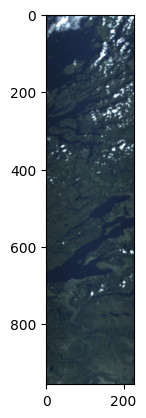

In [54]:
plt.imshow(new_trondheim)

In [71]:
#Preprocess the labeling

new_trondheim_gt = []
y = trondheim_gt.flatten()

for i in range(0,len(y),3): 
    new_trondheim_gt.append(y[i])

new_trondheim_gt = np.array(new_trondheim_gt)

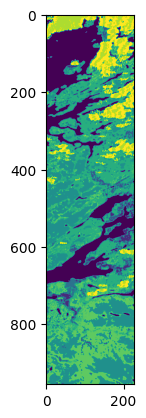

In [74]:
plt.imshow(new_trondheim_gt.reshape(956,228))

In [73]:
classesInLabels(y)

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int16)

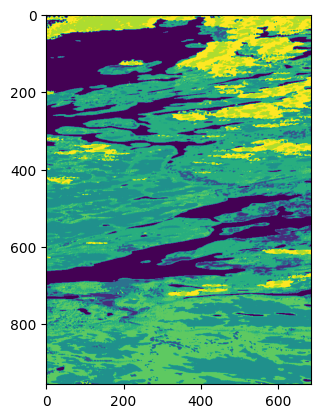

In [28]:
plt.imshow(trondheim_gt["labels"].reshape(956,684))

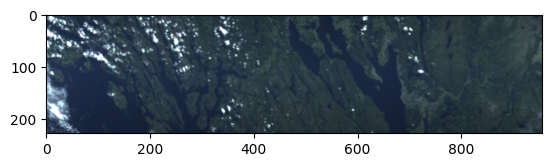

In [27]:
plt.imshow(trondheim_data)

In [48]:
print(trondheim_data)

<PIL.PngImagePlugin.PngImageFile image mode=RGB size=956x228 at 0x2165D5CEB90>


In [40]:
new_cube = np.zeros((95,95,3))
new_cube[:,:,0] = samson[:,31,:]
new_cube[:,:,1] = samson[:,43,:]
new_cube[:,:,2] = samson[:,56,:]
new_cube /= new_cube.max()/2
new_cube[new_cube > 1 ] = 1

plt.imshow(new_cube)
plt.axis('off')
plt.show()

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [238]:
samson = reshape_sj(copy.deepcopy(samson))

X = samson.transpose(0,2,1).reshape((-1,156))
X = preprocessing.scale(X, axis=0)
y = samson_labels.flatten()

# split samson into train test sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.95, random_state=1)

In [239]:
print(len(X[0]))

156


The training time is: 0.013 sec.
The first branch: 0.007
[0 1]
i: 1
The prediction time is: 0.028 sec.
The combination time is: 0.004 sec.
Samson : Linear SMVBDT
Total Accuracy:  98.781 %
Total Support Vectors: 38
Mean Support Vectors: 9.5


C:\Users\jonas\AppData\Local\Temp\ipykernel_27412\4251766610.py:455: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  accuracy = sum(data_and_labels_branch[0][1] == sub_predicted_labels[0])/len(data_and_labels_branch[0][1])


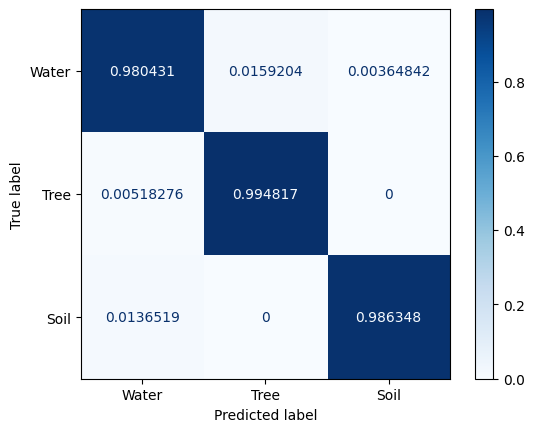

In [240]:
#Samson Linear SVMBDT 

samson_tree = {0: [[2],[0,1]], 1: [[],[[0],[1]]]}

iter = 1e6

#samson_svm_tree = {0: LinearSVC(class_weight= "balanced", max_iter=iter), 
#                  1 : [False,LinearSVC(class_weight= "balanced", max_iter=iter)]}

samson_svm_tree = {0: SVC(kernel = "linear", class_weight= "balanced", max_iter=iter, decision_function_shape="ovr"), 
                  1 : [False,SVC(kernel = "linear", class_weight= "balanced", max_iter=iter, decision_function_shape="ovr")]}

svm_tree_branch, data_and_labels_branches = SvmDesionTreeTrain(X_train, y_train, samson_tree, samson_svm_tree, sub_data=1)

predicted_label, sub_data_branch, predicted_branch_labels = SvmDesionTreePredict(X, svm_tree_branch, samson_tree, sub_data = 1)

total_accuracy = (predicted_label == y).sum()/len(y)

print("Samson : Linear SMVBDT")

print("Total Accuracy: ", str(round(100*total_accuracy,3)), "%")

try: 
    mean_accuracy = MeanAccuracy(data_and_labels_branches, predicted_branch_labels)

    print("Mean Accuracy: ", str(round(100*mean_accuracy,3)), "%")

except: 
    None

samson_support_vectors = SupportVectorsSvmBranches(svm_tree_branch)

samson_total_vectors, samson_mean_vectors = TotalAndMeanSupportVectors(samson_support_vectors)

print("Total Support Vectors: " + str(samson_total_vectors))

print("Mean Support Vectors: " + str(samson_mean_vectors))

#1 Road, 2# Soil, #3, Water, #4 Three

name_classes = ["Water", "Tree", "Soil"]

cm = confusion_matrix(y,predicted_label, normalize="true") 
cmd_obj = ConfusionMatrixDisplay(cm, display_labels=name_classes)
disp = cmd_obj.plot(cmap=plt.cm.Blues,values_format='g')
plt.show()


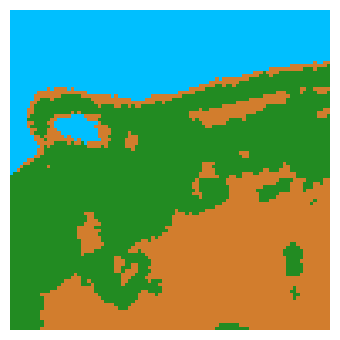

In [189]:
samson_color_label = {0 : [210, 125, 45], 1 : [34,139,34], 2 : [0,191,255]}
samson_classes = ["Water", "Tree", "Soil"]

shape = int(np.sqrt(len(predicted_label)))

predicted_label_color = newColorLabels(predicted_label,shape,samson_color_label)

plt.imshow(predicted_label_color)
plt.axis('off')
plt.show()


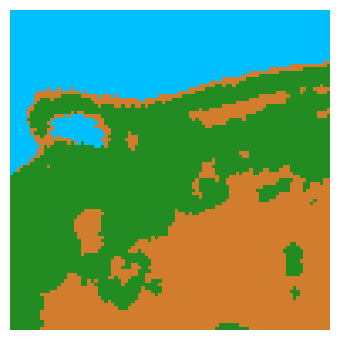

In [143]:
shape = int(np.sqrt(len(y)))

y_color = newColorLabels(y,shape,samson_color_label)

plt.imshow(y_color)
plt.axis('off')
plt.show()


In [328]:
linear_ovo_yout, linear_ovr_yout, rbf_yout, kmeans_yout, knearest_yout,random_forest_yout = SingleMachineLearningTest(X,y,X_train, y_train,1e6)

Linear 1-vs-1 Training Time: 0.005sec.
Linear 1-vs-Rest Training Time: 0.132sec.
RBF Training Time: 0.004167sec.
Kmeans Training Time: 0.047sec.
KNearestNeighbor Training Time: 0.001sec.
KNearestNeighbor Training Time: 0.273sec.
Linear 1-vs-1 Predict Time: 0.017sec.
Linear 1-vs-Rest Predict Time: 0.006sec.
RBF Predict Time: 0.118sec.
KMeans Predict Time: 0.004sec.
KNearestNeighbor Predict Time: 0.387sec.
Random Forest Predict Time: 0.058sec.
Linear 1-vs-1 Accuracy: 98.69%
Linear 1-vs-Rest Accuracy: 97.35000000000001%
RBF Accuracy: 94.77%
KMeans Accuracy: 32.08%
KNearestNeighbour Accuracy: 96.39999999999999%
Random Forest Accuracy: 96.3%
Linear 1-vs-1 Total SVM Support_Vectors : 38
RBF Total SVM Support_Vectors : 95
Linear 1-vs-1 Average SVM Support_Vectors : 12.667
RBF Average SVM Support_Vectors : 31.667


C:\Users\jonas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


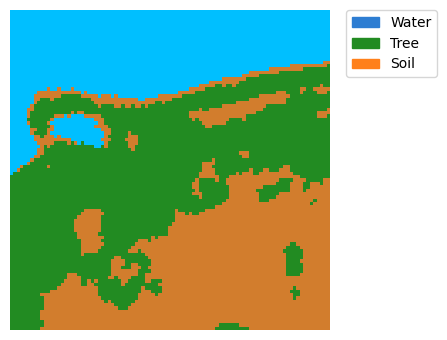

In [156]:
samson_color_label = {0 : [210, 125, 45], 1 : [34,139,34], 2 : [0,191,255]}
t=1
cmap = {0:[0.17647059,0.49019608,0.82352941,t],1:[0.13333333,0.54509804,0.13333333,t],2:[1.0,0.5,0.1,t]}
samson_classes = {0: "Water", 1: "Tree", 2: "Soil"}

hape = int(np.sqrt(len(y)))

yout_color = newColorLabels(y,shape,samson_color_label)

plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

patches = [mpatches.Patch(color=cmap[i], label=samson_classes[i]) for i in samson_color_label] 

plt.imshow(yout_color)
plt.axis('off')
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )
plt.show()

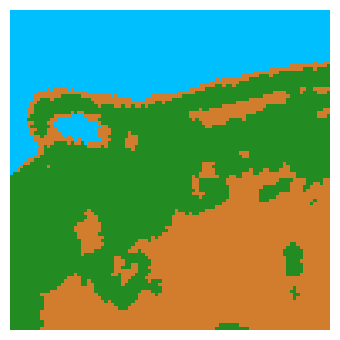

In [137]:
shape = int(np.sqrt(len(linear_ovo_yout)))

linear_ovo_yout_color = newColorLabels(linear_ovo_yout,shape,samson_color_label)

plt.imshow(linear_ovo_yout_color)
plt.axis('off')
plt.show()


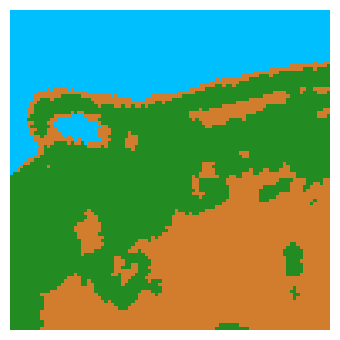

In [138]:
shape = int(np.sqrt(len(linear_ovr_yout)))

linear_ovr_yout_color = newColorLabels(linear_ovr_yout,shape,samson_color_label)

plt.imshow(linear_ovo_yout_color)
plt.axis('off')
plt.show()


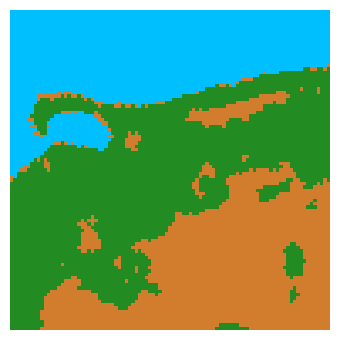

In [139]:
shape = int(np.sqrt(len(rbf_yout)))

rbf_yout_color = newColorLabels(rbf_yout,shape,samson_color_label)

plt.imshow(rbf_yout_color)
plt.axis('off')
plt.show()


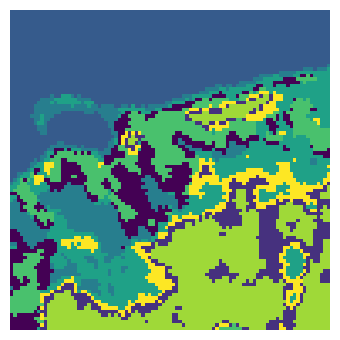

In [140]:
plt.imshow(kmeans_yout.reshape(95,95))
plt.axis('off')
plt.show()


In [132]:
classesInLabels(kmeans_yout)

array([0, 1, 2, 3, 4, 5, 6, 7])

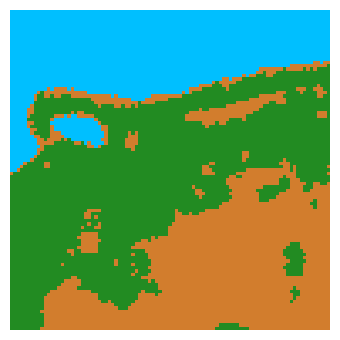

In [141]:
shape = int(np.sqrt(len(knearest_yout)))

knearest_yout_color = newColorLabels(knearest_yout,shape,samson_color_label)

plt.imshow(knearest_yout_color)
plt.axis('off')
plt.show()

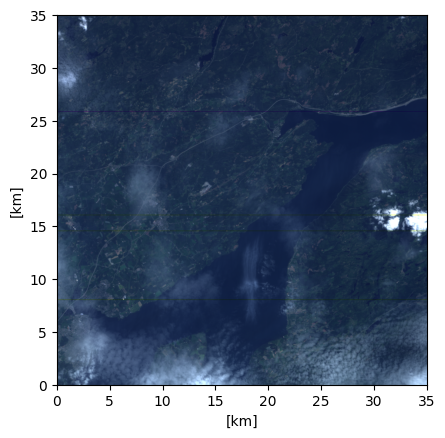

In [38]:
f1 = ta.open_file("../Datasets/2022_07_11_Mjosa/2022_07_11_Mjosa/PRS_L1_STD_OFFL_20220711104640_20220711104644_0001.he5")

d3 = f1.get_node("/HDFEOS/SWATHS/PRS_L1_HRC/")

mjosa_new_cube = np.zeros((1000,1000,3))
mjosa_new_cube[:,:,0] = d3['Data Fields']['VNIR_Cube'][:,31,:]
mjosa_new_cube[:,:,1] = d3['Data Fields']['VNIR_Cube'][:,43,:]
mjosa_new_cube[:,:,2] = d3['Data Fields']['VNIR_Cube'][:,56,:]
mjosa_new_cube /= mjosa_new_cube.max()/2
mjosa_new_cube[mjosa_new_cube > 1 ] = 1

plt.xlabel("[km]")
plt.ylabel("[km]")
plt.imshow(mjosa_new_cube, extent=[0,35,0,35])

In [241]:
def preprocesing_data(data,labels, shape): 
    # prepare data
    X = data.transpose(0,2,1).reshape((-1,shape))
    y = labels.flatten()

    X = preprocessing.scale(X, axis=0)                    # Normalization
    #X = preprocessing.normalize(X, axis=0) 
    return X,y 



In [242]:
X,y = preprocesing_data(data,labels,61)

In [243]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.95, random_state=1)

In [244]:

# 1) Spruce, 2) Pine , 3) Decidous (leaf), 4) Water, 5) Clouds, and 0) other
tb = {0 : [[4],[0,1,2,3,5]], 1 : [[],[[5],[0,1,2,3]]], 2 : [[],[[0],[1,2,3]]], 3 : [[],[[1],[2,3]]], 4 : [[],[[2],[3]]]}

iter = 300

sbm = {0 : LinearSVC(class_weight= "balanced", max_iter=iter),
       1 : [False, LinearSVC(class_weight= "balanced", max_iter=iter)], 
       2 : [False, LinearSVC(class_weight= "balanced", max_iter=iter)],
       3 : [False, LinearSVC(class_weight= "balanced", max_iter=iter)], 
       4 : [False, LinearSVC(class_weight= "balanced", max_iter=iter)]}


L_svm_tree_branches = SvmDesionTreeTrain(X_train, y_train, tb, sbm)

C:\Users\jonas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\jonas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\jonas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\jonas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear 

The training time is: 7.367 sec.


C:\Users\jonas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [245]:
L_predicted_label = SvmDesionTreePredict(X, L_svm_tree_branches, tb)

The first branch: 0.113
[0 5]
i: 1
[0 1]
i: 2
[1 2]
i: 3
[2 3]
i: 4
The prediction time is: 2.036 sec.
[2 3]
class length diff: 0
[1 2 3]
class length diff: 0
[0 1 2 3]
class length diff: 0
The combination time is: 3.118 sec.


0.72849

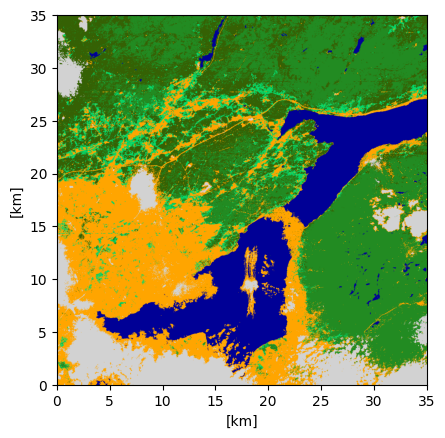

In [246]:
mjosa_color_label = {0: [255,165,0], 1: [34,139,34], 2: [53, 97, 4], 3: [5, 216, 105], 4 : [0,0,150], 5 : [210,210,210]}


new_labels = newColorLabels(L_predicted_label,1000, mjosa_color_label)
plt.xlabel("[km]")
plt.ylabel("[km]")
plt.imshow(new_labels, extent=[0,35,0,35])

sum(L_predicted_label == y)/len(y)

In [255]:
classesInLabels(L_predicted_label)

array([0, 4, 5], dtype=uint8)

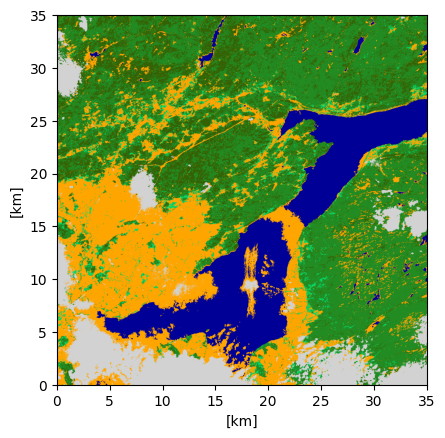

In [309]:
mjosa_color_label = {0: [255,165,0], 1: [34,139,34], 2: [53, 97, 4], 3: [5, 216, 105], 4 : [0,0,150], 5 : [210,210,210]}


new_y = newColorLabels(y,1000, mjosa_color_label)
plt.xlabel("[km]")
plt.ylabel("[km]")
plt.imshow(new_y, extent=[0,35,0,35])

In [247]:

# 1) Spruce, 2) Pine , 3) Decidous (leaf), 4) Water, 5) Clouds, and 0) other
tb = {0 : [[0,1,2,3],[4,5]], 1 : [[[0],[1,2,3]],[[4],[5]]], 2 : [[[1],[2,3]],[]], 3 : [[[2],[3]],[]]}

iter = 1e3

sbm = {0 :  LinearSVC(class_weight= "balanced", max_iter=iter), 
       1 : [LinearSVC(class_weight= "balanced", max_iter=iter), LinearSVC(class_weight= "balanced", max_iter=iter)], 
       2 : [LinearSVC(class_weight= "balanced", max_iter=iter), False], 
       3 : [LinearSVC(class_weight= "balanced", max_iter=iter), False]}

svm_tree_branches = SvmDesionTreeTrain(X_train, y_train, tb, sbm)

C:\Users\jonas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\jonas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\jonas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


The training time is: 33.942 sec.


C:\Users\jonas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [248]:
predicted_label = SvmDesionTreePredict(X, svm_tree_branches, tb)

The first branch: 0.107
[0 1]
i: 1
[4 5]
i: 1
[1 2]
i: 2
[2 3]
i: 3
The prediction time is: 1.649 sec.
[2 3]
class length diff: 0
[1 2 3]
class length diff: 0


C:\Users\jonas\AppData\Local\Temp\ipykernel_27412\4251766610.py:356: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if(yout_sub_1 == []):
C:\Users\jonas\AppData\Local\Temp\ipykernel_27412\4251766610.py:365: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  elif(yout_sub_2 == []):


The combination time is: 5.053 sec.


0.67427

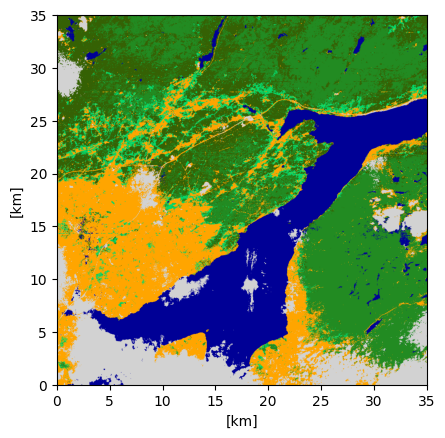

In [249]:
mjosa_color_label = {0: [255,165,0], 1: [34,139,34], 2: [53, 97, 4], 3: [5, 216, 105], 4 : [0,0,150], 5 : [210,210,210]}


new_labels = newColorLabels(predicted_label,1000, mjosa_color_label)
plt.xlabel("[km]")
plt.ylabel("[km]")
plt.imshow(new_labels, extent=[0,35,0,35])

sum(predicted_label == y)/len(y)

In [308]:
classesInLabels(predicted_label)

array([0, 1, 2, 3, 4, 5], dtype=uint8)

In [105]:
predicted_label = SvmDesionTreePredict(X, svm_tree_branches, tb)

The first branch: 10.835
Individal predict time:20.644
Individal predict time:3.929
Individal predict time:14.013
Individal predict time:13.441
The prediction time is: 63.806 sec.
The combination time is: 3.328 sec.


In [106]:
print(sum(predicted_label == y)/len(y))

mjosa_support_vectors = SupportVectorsSvmBranches(svm_tree_branches)

mjosa_total_vectors, mjosa_mean_vectors = TotalAndMeanSupportVectors(mjosa_support_vectors)

print("Total Support Vectors: " + str(mjosa_total_vectors))

print("Mean Support Vectors: " + str(mjosa_mean_vectors))

0.339034
Total Support Vectors: 4271
Mean Support Vectors: 427.1


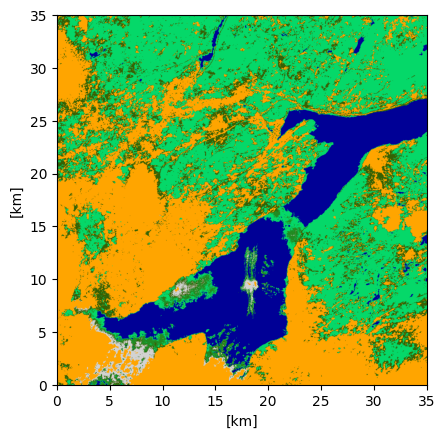

In [107]:
mjosa_color_label = {0: [255,165,0], 1: [34,139,34], 2: [53, 97, 4], 3: [5, 216, 105], 4 : [0,0,150], 5 : [210,210,210]}


new_labels = newColorLabels(predicted_label,1000, mjosa_color_label)
plt.xlabel("[km]")
plt.ylabel("[km]")
plt.imshow(new_labels, extent=[0,35,0,35])

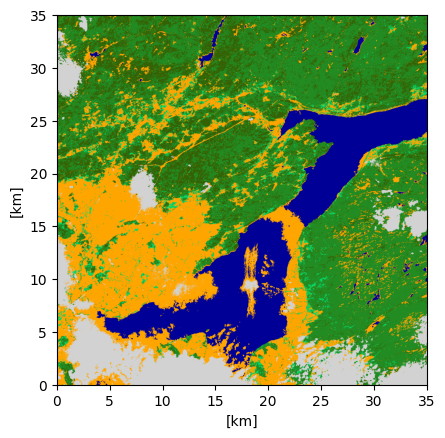

In [142]:
mjosa_color_label = {0: [255,165,0], 1: [34,139,34], 2: [53, 97, 4], 3: [5, 216, 105], 4 : [0,0,150], 5 : [210,210,210]}


new_y = newColorLabels(y,1000, mjosa_color_label)
plt.xlabel("[km]")
plt.ylabel("[km]")
plt.imshow(new_y, extent=[0,35,0,35])

In [ ]:
total_accuracy = (predicted_label == y).sum()/len(y)

print("Samson : RBF SMVBDT")

print("Total Accuracy: ", str(round(100*total_accuracy,3)), "%")

try: 
    mean_accuracy = MeanAccuracy(data_and_labels_branches, predicted_branch_labels)

    print("Mean Accuracy: ", str(round(100*mean_accuracy,3)), "%")

except: 
    None

mjosa_support_vectors = SupportVectorsSvmBranches(svm_tree_branch)

mjosa_total_vectors, mjosa_mean_vectors = TotalAndMeanSupportVectors(mjosa_support_vectors)

print("Total Support Vectors: " + str(mjosa_total_vectors))

print("Mean Support Vectors: " + str(mjosa_mean_vectors))

In [ ]:
linear_ovo_yout, linear_ovr_yout, rbf_yout, kmeans_yout, knearest_yout = SingleSVMTest(X,y,X_train, y_train,1e6)

In [ ]:
samson_color_label = {0 : [210, 125, 45], 1 : [34,139,34], 2 : [0,191,255]}
t=1
cmap = {0:[0.17647059,0.49019608,0.82352941,t],1:[0.13333333,0.54509804,0.13333333,t],2:[1.0,0.5,0.1,t]}
samson_classes = {0: "Water", 1: "Tree", 2: "Soil"}

hape = int(np.sqrt(len(y)))

yout_color = newColorLabels(y,shape,samson_color_label)

plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

patches = [mpatches.Patch(color=cmap[i], label=samson_classes[i]) for i in samson_color_label] 

plt.imshow(yout_color)
plt.axis('off')
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )
plt.show()

In [15]:
mjosa_color_label = {0: [255,165,0], 1: [34,139,34], 2: [53, 97, 4], 3: [5, 216, 105], 4 : [0,0,150], 5 : [210,210,210]}


In [1]:
new_y = newColorLabels(linear_ovo_yout,1000, mjosa_color_label)
plt.xlabel("[km]")
plt.ylabel("[km]")
plt.imshow(new_y, extent=[0,35,0,35])

NameError: name 'newColorLabels' is not defined

In [ ]:
new_y = newColorLabels(linear_ovr_yout,1000, mjosa_color_label)
plt.xlabel("[km]")
plt.ylabel("[km]")
plt.imshow(new_y, extent=[0,35,0,35])

In [ ]:
new_y = newColorLabels(rbf_yout,1000, mjosa_color_label)
plt.xlabel("[km]")
plt.ylabel("[km]")
plt.imshow(new_y, extent=[0,35,0,35])

In [ ]:
new_y = newColorLabels(kmeans_yout,1000, mjosa_color_label)
plt.xlabel("[km]")
plt.ylabel("[km]")
plt.imshow(new_y, extent=[0,35,0,35])

In [ ]:
new_y = newColorLabels(knearest_yout,1000, mjosa_color_label)
plt.xlabel("[km]")
plt.ylabel("[km]")
plt.imshow(new_y, extent=[0,35,0,35])

In [75]:
#Single SVM Linear and RBF
def SingleSVMTest(data, label, train_data, train_label, iter): 

    #Add k-means and k-nearest neighbour

    import time

    #Define different machine learning algoritms

    svm_linear_ovr = LinearSVC(class_weight= "balanced", max_iter=iter)


    #Train the different models with printing of training time. 


    start_time = time.time()

    svm_linear_ovr.fit(train_data, train_label)

    stop_time = time.time() 

    print("Linear 1-vs-Rest Training Time: " + str(round(stop_time - start_time, 3)) + "sec.")

    
    #Predict the different models with time. 

    start_time = time.time()

    linear_ovr_yout = svm_linear_ovr.predict(data)

    stop_time = time.time()

    print("Linear 1-vs-Rest Predict Time: " + str(round(stop_time - start_time, 3)) + "sec.")



    print("Linear 1-vs-Rest Accuracy: " + str(100*round(sum(linear_ovr_yout == label)/len(label),4)) + "%")


    return linear_ovr_yout

In [76]:
linear_ovr_yout = SingleSVMTest(X,y,X_train, y_train,1e2)

NameError: name 'X' is not defined

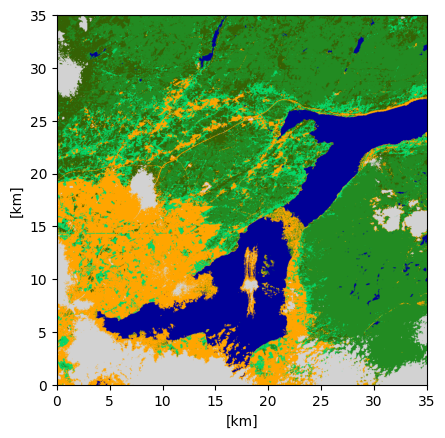

In [140]:
mjosa_color_label = {0: [255,165,0], 1: [34,139,34], 2: [53, 97, 4], 3: [5, 216, 105], 4 : [0,0,150], 5 : [210,210,210]}

new_linear = newColorLabels(linear_ovr_yout,1000, mjosa_color_label)
plt.xlabel("[km]")
plt.ylabel("[km]")
plt.imshow(new_linear, extent=[0,35,0,35])

In [109]:
linear_ovo_yout, linear_ovr_yout, rbf_yout, kmeans_yout, knearest_yout,random_forest_yout = SingleMachineLearningTest(X,y,X_train, y_train,1e3)

C:\Users\jonas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Linear 1-vs-1 Training Time: 0.97sec.


C:\Users\jonas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Linear 1-vs-Rest Training Time: 1.104sec.


C:\Users\jonas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


RBF Training Time: 1.573002sec.
Kmeans Training Time: 0.244sec.
KNearestNeighbor Training Time: 0.01sec.
KNearestNeighbor Training Time: 0.61sec.
Linear 1-vs-1 Predict Time: 25.79sec.
Linear 1-vs-Rest Predict Time: 0.022sec.
RBF Predict Time: 118.65sec.
KMeans Predict Time: 0.005sec.
KNearestNeighbor Predict Time: 4.083sec.
Random Forest Predict Time: 3.313sec.
Linear 1-vs-1 Accuracy: 42.93%
Linear 1-vs-Rest Accuracy: 60.089999999999996%
RBF Accuracy: 42.480000000000004%
KMeans Accuracy: 1.87%
KNearestNeighbour Accuracy: 68.60000000000001%
Random Forest Accuracy: 67.2%
Linear 1-vs-1 Total SVM Support_Vectors : 7279
RBF Total SVM Support_Vectors : 7292
Linear 1-vs-1 Average SVM Support_Vectors : 808.778
RBF Average SVM Support_Vectors : 810.222


In [250]:

X = np.array(new_trondheim).reshape((-1,3))
X = preprocessing.scale(X, axis=0)
y = new_trondheim_gt.flatten()

C:\Users\jonas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\preprocessing\_data.py:239: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
C:\Users\jonas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\preprocessing\_data.py:258: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(


In [251]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.95, random_state=1)

In [102]:
linear_ovr_yout = SingleSVMTest(X,y,X_train, y_train,1e5)

Linear 1-vs-Rest Training Time: 2.546sec.
Linear 1-vs-Rest Predict Time: 0.023sec.
Linear 1-vs-Rest Accuracy: 60.089999999999996%


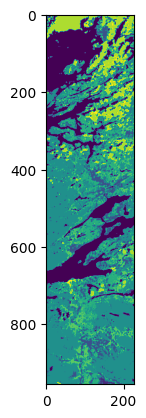

In [108]:
plt.imshow(linear_ovr_yout.reshape(956,228))

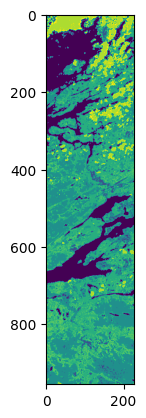

In [110]:
plt.imshow(knearest_yout.reshape(956,228))

In [352]:
# 2) Water, 3) Cropland, 4) Pasture, 5) City, 6) Rock, 7) Thin Forest, 8) Thick Forest, 9) Cloud, 10) Thin Cloud
tb = {0 : [[2,9,10],[3,4,5,6,7,8]], 
      1 : [[[2],[9,10]],[[3],[4,5,6,7,8]]],
      2 : [[[9],[10]],[[6],[5,4,7,8]]], 
      3 : [[],[[4],[5,7,8]]], 
      4 : [[],[[5],[7,8]]], 
      5 : [[],[[7],[8]]]}

iter = 1e6

sbm = {0 :  LinearSVC(class_weight= "balanced", max_iter=iter), 
       1 : [LinearSVC(class_weight= "balanced", max_iter=iter), LinearSVC(class_weight= "balanced", max_iter=iter)], 
       2 : [LinearSVC(class_weight= "balanced", max_iter=iter), LinearSVC(class_weight= "balanced", max_iter=iter)], 
       3 : [False, LinearSVC(class_weight= "balanced", max_iter=iter)], 
       4 : [False, LinearSVC(class_weight= "balanced", max_iter=iter)], 
       5 : [False, LinearSVC(class_weight= "balanced", max_iter=iter)]
       }

svm_tree_branches = SvmDesionTreeTrain(X_train, y_train, tb, sbm)

The training time is: 0.603 sec.


In [353]:
predicted_label, sub_data_branch, predicted_branch_labels  = SvmDesionTreePredict(X, svm_tree_branches, tb, sub_data = 1)

The first branch: 0.005
The prediction time is: 0.133 sec.


C:\Users\jonas\AppData\Local\Temp\ipykernel_27412\3377359057.py:261: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if(yout_sub_1 == []):
C:\Users\jonas\AppData\Local\Temp\ipykernel_27412\3377359057.py:270: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  elif(yout_sub_2 == []):


The combination time is: 1.518 sec.


In [354]:
print(classesInLabels(predicted_branch_labels[5][1]))

[7 8]


In [355]:
np.sum(predicted_label == y)/len(y)

0.593536665932614

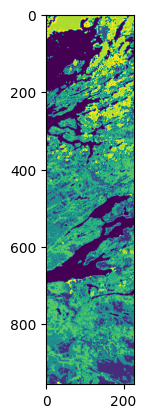

In [356]:
plt.imshow(predicted_label.reshape(956,228))

In [357]:
classesInLabels(predicted_label)

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int16)